# Introduction

This calculates the exact eigenvectors, eigenvalues and VAMP scores for the Quad Well potential in MSM Builder.  The exact VAMP scores are calculated using a discrete basis set with discretisations of various sizes over the range -1.2 to 1.2 using.  The exact eigenvectors/values are calculated using a very fine grid spacing.   

## Imports and defaults

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy
import pandas as pd
from pyemma.util.metrics import vamp_score
from matplotlib.ticker import MultipleLocator


In [2]:
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
def _normalize_eigensystem(u, lv, rv):
    """Normalize the eigenvectors of a reversible Markov state model according
    to our preferred scheme.
    """
    # first normalize the stationary distribution separately
    pi = lv[:, 0]
    lv[:, 0] = lv[:, 0] / np.sum(lv[:, 0])
    
    for i in range(1, lv.shape[1]):
        # the remaining left eigenvectors to satisfy
        # <\phi_i, \phi_i>_{\mu^{-1}} = 1
        lv[:, i] = lv[:, i] / np.sqrt(np.dot(lv[:, i], lv[:, i] / lv[:, 0]))

    for i in range(rv.shape[1]):
        # the right eigenvectors to satisfy <\phi_i, \psi_j> = \delta_{ij}
        rv[:, i] = rv[:, i] / np.dot(lv[:, i], rv[:, i])

    return u, lv, rv, pi

In [4]:
def _solve_msm_eigensystem(transmat, k):
    u, lv, rv = scipy.linalg.eig(transmat, left=True, right=True)
    order = np.argsort(-np.real(u))
    u = np.real_if_close(u[order[:k]])
    lv = np.real_if_close(lv[:, order[:k]])
    rv = np.real_if_close(rv[:, order[:k]])
    return _normalize_eigensystem(u, lv, rv)


In [5]:
def _reflect_boundary_conditions(x, min, max):
    if x > max:
        return 2 * max - x
    if x < min:
        return 2 * min - x
    return x

def brownian_transmat(n_grid, lag_time, xmin, xmax, A, B, C, reflect_bc):
    ONE_OVER_SQRT_2PI = 1.0 / (np.sqrt(2 * np.pi))
    
    normalpdf = lambda x: ONE_OVER_SQRT_2PI * np.exp(-0.5 * (x * x))

    grad_potential = lambda x: 4 * (
    8 * x ** 7 - C*128 * x * np.exp(-80 * x ** 2) - \
    B*32 * (x - 0.5) * np.exp(-80 * (x - 0.5) ** 2) - A*40 * (x + 0.5) * np.exp(
        -40 * (x + 0.5) ** 2)) 
    
    DIFFUSION_CONST = 1e3
    DT = 1e-3
    DT_SQRT_2D = DT * np.sqrt(2 * DIFFUSION_CONST)

    grid = np.linspace(xmin, xmax, n_grid)
    width = grid[1] - grid[0]
    transmat = np.zeros((n_grid, n_grid))
    for i, x_i in enumerate(grid):
        if reflect_bc:
            for offset in range(-(n_grid - 1), n_grid):
                x_j = x_i + (offset * width)
                j = _reflect_boundary_conditions(i + offset, 0, n_grid - 1)

                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)
        else:
            for j, x_j in enumerate(grid):
                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)

        transmat[i, :] = transmat[i, :] / np.sum(transmat[i, :])
    transmat = np.linalg.matrix_power(transmat, lag_time)
    return transmat

def potential(x, A, B, C):
    return 4 * (x ** 8 + C*0.8 * np.exp(-80 * (x ** 2)) + B*0.2 * np.exp(
        -80 * (x - 0.5) ** 2) +
                A*0.5 * np.exp(-40 * (x + 0.5) ** 2)) 

/Users/robert_arbon/anaconda/envs/sonification/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.2, you have 2.5.1.
  .format(latest=latest, current=current), category=UserWarning)


In [6]:
A = 1
B = 1
C = 1
tau = 8

[ 844.43487944  125.53250276   64.27758341   11.87013711   10.2959915
    7.30592912    6.68324501    4.42840621    4.1497171 ]


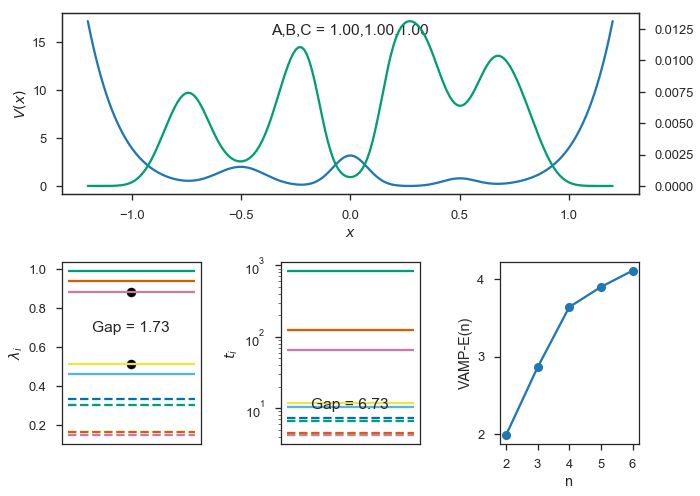

In [7]:
# ticker = MultipleLocator(base=1)
from scipy.stats.mstats import gmean
xmin, xmax = -1.2, 1.2
N = 200
kmax = 10
cols = sns.color_palette('colorblind', kmax)

x = np.linspace(xmin, xmax, N)
T = brownian_transmat(N, tau, xmin, xmax, A, B, C, False)
u, lv, rv, pi = _solve_msm_eigensystem(T, N)

mu = np.real(lv[:,0])
C_00 = np.diag(mu)
C_11 = np.diag(mu)
C_01 = np.dot(C_00, T)

ts = np.array([-tau/np.log(u[i]) for i in range(1,kmax)])
print(ts)
resolve_ts = [t for t in ts if t > tau]
num_resolve_ts = len(resolve_ts)

gaps = [u[i]/u[i+1] for i in range(4)]
ts_gaps = [ts[i]/ts[i+1] for i in range(4)]

m_max = np.argmax(gaps)
gap_m = [m_max, m_max+1]

score_ks = np.arange(2,num_resolve_ts+2)

scores = [vamp_score(T, C_00, C_01, C_11, C_00, C_01, C_11, k, score='vampe') for k in score_ks]

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (1, 1))
ax4 = plt.subplot2grid((3, 3), (1, 2))
axes = [ax1,ax2,ax3,ax4]

axes[0].plot(x, potential(x,A,B,C))
tw_ax = axes[0].twinx()
tw_ax.plot(x, mu, color=cols[1])

axes[0].text(x = 0.5, y=0.9,s='A,B,C = {0:4.2f},{1:4.2f},{2:4.2f}'.format(A,B,C), 
             transform=axes[0].transAxes, verticalalignment='center', horizontalalignment='center' )
axes[0].set_ylabel('$V(x)$')
axes[0].set_xlabel('$x$')

_ = [axes[1].hlines(xmin=0,xmax=1, y=u[i], color=cols[i]) if i <= num_resolve_ts else  
     axes[1].hlines(xmin=0,xmax=1, y=u[i], color=cols[i], linestyle='--') for i in range(1,kmax)]
_ = [axes[1].scatter(x=0.5, y=u[m], color='k', marker='o') for m in gap_m ]
axes[1].text(s='Gap = {:4.2f}'.format(np.max(gaps)), x=0.5, y=np.mean(u[gap_m]),
            verticalalignment='center', horizontalalignment='center' )
axes[1].set_ylabel('$\lambda_i$')
axes[1].tick_params(axis = 'x', bottom=False, labelbottom=False)

_ = [axes[2].hlines(xmin=0,xmax=1, y=-tau/np.log(u[i]), color=cols[i])  if i <= num_resolve_ts else
     axes[2].hlines(xmin=0,xmax=1, y=-tau/np.log(u[i]), color=cols[i], linestyle='--') for i in range(1,kmax)]
axes[2].text(s='Gap = {:4.2f}'.format(np.max(ts_gaps)), x=0.5, y=gmean(ts[gap_m]), 
             verticalalignment='center', horizontalalignment='center' )
axes[2].tick_params(axis = 'x', bottom=False, labelbottom=False)
axes[2].set_yscale('log')
axes[2].set_ylabel('$t_i$')


axes[3].plot(score_ks, scores, marker='o')
axes[3].xaxis.set_major_locator(MultipleLocator(base=1))
# axes[3].set_ylim(1,5)
axes[3].yaxis.set_major_locator(MultipleLocator(base=1))
axes[3].set_ylabel('VAMP-E(n)')
axes[3].set_xlabel('n')

plt.gcf().set_size_inches(10,10)
plt.tight_layout()


### Lag time/implied timescales/separation. 

We want a lag-time for which the timescale separation/eigenvalue separation is large. 

In [517]:
orig =  np.array([1.        , 0.99881648, 0.99206558, 0.98456287, 0.919206  ,
       0.90744241, 0.87207912, 0.86102829, 0.79786579, 0.78585712])

T = brownian_transmat(n_grid=N, lag_time=1, grad_potential=QUADWELL_GRAD_POTENTIAL, 
                      xmin=xmin, xmax=xmax, reflect_bc=False)
u, lv, rv, pi =  _solve_msm_eigensystem(T, N)


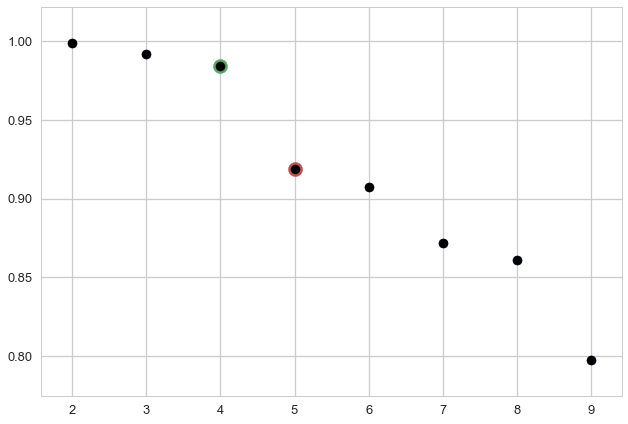

In [518]:
start, stop = 1, 4
gaps = [u[i]/u[i+1] for i in range(start,stop)]
m_max_gap = np.argmax(gaps)+1
max_gap = np.max(gaps)

plt.scatter(np.arange(2,10), u[1:9])
plt.scatter(m_max_gap+1,u[m_max_gap],s=200)
plt.scatter(m_max_gap+2,u[m_max_gap+1], s=200)
plt.scatter(np.arange(2,10), orig[1:9], marker='o', c='k')
# plt.plot(np.arange(2,2+len(gaps)), gaps, ls='', marker='o')

# plt.text(s='Gap {0:4.2f}, m = {1}'.format(max_gap, m_max_gap), x=m_max_gap, y = u[m_max_gap]*0.8,)
# plt.ylim(0.5,1.1)
# plt.yscale('log')


/Users/robert_arbon/anaconda/envs/sonification/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


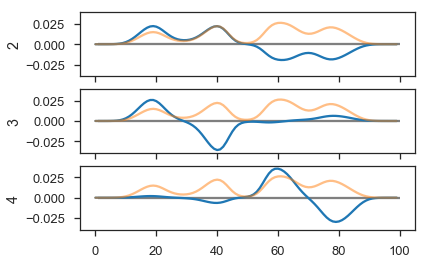

In [29]:
n = 3
fig, axes = plt.subplots(n, sharey=True, sharex=True)

for i in range(n):
    axes[i].plot(lv[:,i+1])
    axes[i].plot(pi, alpha=0.5)
    axes[i].set_ylabel('{}'.format(i+2))
    axes[i].hlines(0,len(pi),1, alpha=0.5)
# plt.plot(pi*100)

In [520]:
gaps = []
m = []
taus = np.arange(1, 500, 1)
k = 4
for i in taus:
    gaps.append(np.max(u[:k]**i/u[1:k+1]**i))
    m.append(np.argmax(u[:k]**i/u[1:k+1]**i)+1)
#     plt.plot(u[:10]**i, marker='o',  label='tau = {}'.format(i))
gaps = np.array(gaps)
m = np.array(m)

max_gap = np.max(gaps)
tau_at_max = taus[np.argmax(gaps)]
m_at_max = m[np.argmax(gaps)]

(0.1, 15)

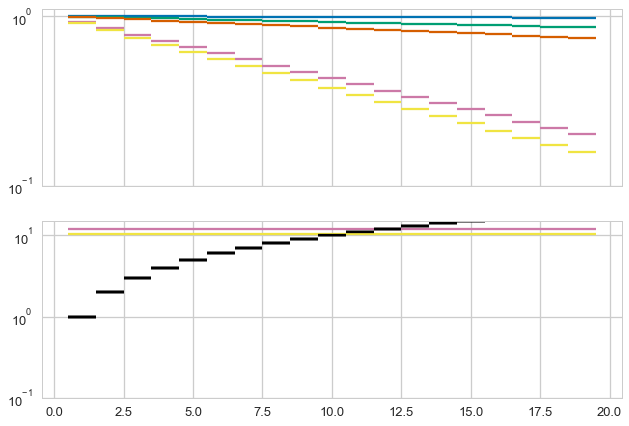

In [524]:
fig, ax = plt.subplots(2, sharex=True)
max_k = 5
del_tau = 1
del_t = 0.5*del_tau
cols = sns.color_palette('colorblind', max_k)
taus = np.arange(1,20,del_tau)
for t in taus:
    for k in range(1,max_k+1):
        ax[0].hlines(xmin=t-del_t, xmax=t+del_t, y=u[k]**t,color=cols[k-1])
        ax[1].hlines(xmin=t-del_t, xmax=t+del_t,y=-t/np.log(u[k]**t), color=cols[k-1])
        ax[1].hlines(xmin=t-del_t, xmax=t+del_t,y=t, color='k')
ax[0].set_yscale('log')
ax[0].set_ylim(1e-1, 1.1)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-1, 15)



In [499]:
# fig, ax = plt.subplots()

# cols = sns.color_palette('colorblind', 3)
# ax.plot(taus, gaps, label=r'$\Delta \lambda_{max}$', c= cols[0])

# ax2 = ax.twinx()
# ax2.plot(taus, m, label=r'$m$', c=cols[1])
# # ax.scatter(tau_at_max, max_gap)

# # text = r'$\tau = {0}, m = {1}$'.format(tau_at_max, m_at_max)
# # t = ax.text(x=tau_at_max, y=max_gap+0.05, s=text)
# # t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

# # ax.vlines(tau_at_max,0, max_gap, color=cols[0], linestyles='dashed')


# # lines, labels = ax.get_legend_handles_labels()
# # # lines2, labels2 = ax2.get_legend_handles_labels()
# # # ax.legend(lines, labels, loc=0)
# # ax.set_ylim((0,1))
# ax.set_ylabel(r'$\max[\lambda_{m}/\lambda_{m+1}]$')
# ax.set_xlabel(r'$\tau$')

In [500]:
tau_at_max=10

## Potenial/Stationary distribution figure

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/matplotlib/axes/_axes.py:4830: ComplexWarning: Casting complex values to real discards the imaginary part
  X[1:N + 1, 1] = y1slice
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


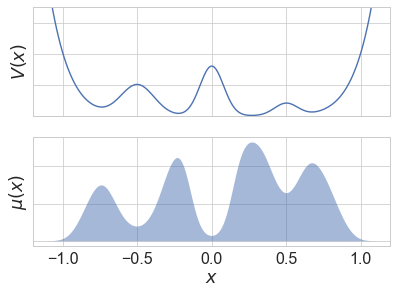

In [501]:
with sns.plotting_context('paper', font_scale=2):
    x = np.linspace(xmin, xmax, N)
    y = potential(x)
    y_stat = pi

    fig, [ax1,ax2] = plt.subplots(2, sharex=True)
    ax1.plot(x,y, label='Potential:\n$V(x) = 4(x^8+0.8 e^{-80 x^2}+0.2 e^{-80 (x-0.5)^2}+0.5 e^{-40 (x+0.5)^2})$')
    ax1.set_xlim((xmin,xmax))
    y1max = 7
    ax1.set_ylim((0,y1max))
    ax1.set_ylabel(r'$V(x)$')

    # y2min = np.floor(np.min(y_stat))
    ax2.fill_between(x, y1=y_stat, y2=0, alpha=0.5, label='Stationary Distribution')
    # ax2.set_ylim(y2min,y2min+y1max)
    ax2.set_xlim((xmin, xmax))

    ax2.set_ylabel(r'$\mu(x)$')
    ax2.set_xlabel(r'$x$')
    for ax in [ax1, ax2]:
        ax.tick_params(
            axis='both',          
            which='both',      
            left='off', 
            right='off',
            top='off',         
            labelleft='off')

    plt.savefig('figures/potential_and_pi.pdf',bbox_inches='tight',  transparent=False)


In [22]:
T = brownian_transmat(n_grid=100, lag_time=20, xmin=-1.2, xmax=1.2, A=1, B=1, C=1, reflect_bc=False)
u, lv, rv, pi = _solve_msm_eigensystem(T, N)


In [26]:
T.sum(axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [31]:
np.save('fourwell_T_lag1.npy', T)

In [32]:
np.savetxt('fourwell_T_lag1.txt', T)

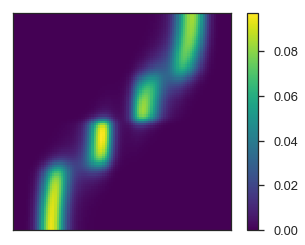

In [23]:

plt.imshow(T, origin='lower', cmap='viridis')
plt.xticks([])
plt.yticks([])
plt.colorbar()
# plt.savefig('figures/T.png', transparent=True)

## Converge VAMP scores

In [504]:
from numpy.linalg import multi_dot as mdot
from numpy.linalg import svd
from pyemma.util.metrics import vamp_score


In [505]:
ts = -tau_at_max/np.log(u[1:])
ts[np.where(ts>tau_at_max)]

array([844.43487944, 125.53250276,  64.27758341,  11.87013711,
        10.2959915 ])

In [506]:
n_states = [500]
ks = np.arange(2,10,1).astype(int)
methods = ['vamp1', 'vamp2', 'vampe']
xmin, xmax = -1.2, 1.2
data = {'m': [], 'k': [], 'method': [], 'score': []}

for n_state in n_states:
    T = brownian_transmat(n_grid=n_state, lag_time=int(tau_at_max), grad_potential=QUADWELL_GRAD_POTENTIAL, 
                      xmin=xmin, xmax=xmax, reflect_bc=False)
    u, lv, rv, _ =  _solve_msm_eigensystem(T, n_state)
    mu = np.real(lv[:,0])
    C_00 = np.diag(mu)
    C_11 = np.diag(mu)
    C_01 = np.dot(C_00, T)
    for k in ks:
        for method in methods:
            score = vamp_score(T, C_00, C_01, C_11, C_00, C_01, C_11, k, score=method)
            data['m'].append(n_state)
            data['k'].append(k)
            data['method'].append(method)
            data['score'].append(score)



In [507]:
df = pd.DataFrame(data)
df['m'].unique()
# df.loc[df['m']==500, :].to_pickle('vamp_exact_values.pickl')

array([500])

In [508]:
df.loc[(df['m']==500) & (df['method']=='vampe'),]

,k,m,method,score
2,2,500,vampe,1.976596
5,3,500,vampe,2.829321
8,4,500,vampe,3.561929
11,5,500,vampe,3.747394
14,6,500,vampe,3.890741
17,7,500,vampe,3.955476
20,8,500,vampe,4.005638
23,9,500,vampe,4.016569


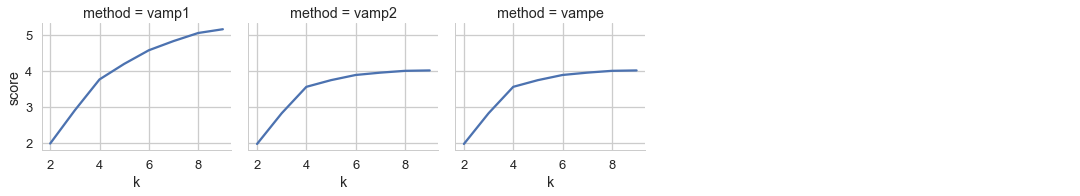

In [509]:
g = sns.FacetGrid(col='method', col_wrap=5, data=df)
g.map(plt.plot, 'k', 'score').add_legend()
# g.set(ylim=(2.95,2.96))
# g.set(yscale='log', xlim=(5,400))


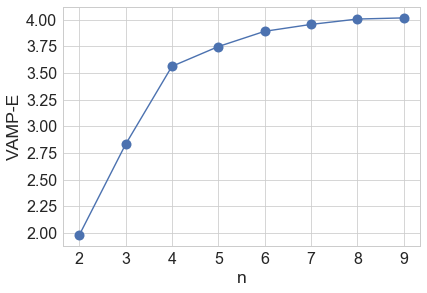

In [510]:
with sns.plotting_context('paper', font_scale=2):
    sns.set_style('whitegrid')
    y = df.loc[df['method']=='vampe', 'score']
    x = df.loc[df['method']=='vampe', 'k']
    plt.plot(x, y, marker='o', ms=10)
    plt.ylabel('VAMP-E')
    plt.xlabel('n')
#     plt.ylim(2.02,2.04)
    plt.savefig('figures/vampe_vs_n.pdf')
    


## VAMP vs k: 

In [ ]:
m_exact = 500
g = sns.FacetGrid(hue='method', data=df.loc[df['m']==m_exact, :])
g.map(plt.plot, 'k', 'score').add_legend()



## Implied timescales

In [ ]:
T = brownian_transmat(n_grid=n_state, lag_time=int(tau_at_max), grad_potential=QUADWELL_GRAD_POTENTIAL, 
                  xmin=xmin, xmax=xmax, reflect_bc=False)
u, lv, rv, _, = _solve_msm_eigensystem(T, n_state)

In [ ]:
u2 = u[1:11]
du2 = u2[:-1]/u2[1:]

In [ ]:
its = -tau_at_max/np.log(u2)
dits = its[:-1]/its[1:]

In [ ]:
with sns.plotting_context('paper', font_scale=1.5):
    
    its_lab = ['$t_1=\infty$'] + ['$t_{%d}' % (i+2) + '={0:4.1f}$'.format(x) for i, x in enumerate(its)]
    plt.scatter(np.arange(len(u[:10]))+1, u[:10], marker='o')
    offset=[0]+[-0.02]*len(u[1:10])
    for i, x in enumerate(its_lab[:5]): 
        plt.text((i+1.15), u[i]+offset[i], x)
    plt.ylabel('$\lambda_{i}$')
    plt.xlabel('i')
    plt.ylim((0,1.1))
    plt.savefig('figures/eigenspectrum.png', bbox_inches='tight', transparent = True)

In [ ]:
from matplotlib.ticker import MultipleLocator
ticker = MultipleLocator(base=2)
with sns.plotting_context('paper', font_scale=2):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2,2, sharex=True)
    idx = np.arange(u2.shape[0])+2
    didx = idx[:-1]
    
    ax =  axes[0,0]
    ax.scatter(idx, u2)
    ax.set_ylabel('$\lambda_i$')
    
    ax = axes[0,1]
    ax.scatter(idx, its)
    ax.set_ylabel('$t_i$')
    ax.hlines(tau_at_max, idx[0]-0.5, idx[-1]+0.5)
    ax.text( idx[-1], tau_at_max+10, r'$\tau$ = 30',horizontalalignment='right')
    ax.set_yscale('log')

    ax = axes[1,0]
    ax.scatter(didx, du2)
    ax.set_ylabel('$\lambda_i/\lambda_{i+1}$')
    ax.yaxis.set_major_locator(ticker)
    ax.set_ylim((0,11))
    
    ax = axes[1,1]
    ax.scatter(didx, dits)
    ax.set_ylabel('$t_i/t_{i+1}$')
    ax.yaxis.set_major_locator(ticker)
    ax.set_ylim((0,11))



    
    for ax in axes[1,:]:
        ax.set_xlabel('Process i')
        
    plt.tight_layout()
    plt.savefig('figures/gaps.pdf', transparent=False, bbox_inches='tight')

In [ ]:
plt.plot(lv[:,5])
plt.plot(lv[:, 0])